# Predict and Extract Features with Pre-trained Models

This tutorial will work through how to use pre-trained models for predicting and feature extraction.

## Download pre-trained models

A model often contains two parts, the `.json` file specifying the neural network structure, and the `.params` file containing the binary parameters. The name convention is `name-symbol.json` and `name-epoch.params`, where `name` is the model name, and `epoch` is the epoch number. 


Here we download a pre-trained Resnet 50-layer model on Imagenet. Other models are available at http://data.mxnet.io/models/

In [1]:
import os, urllib
def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.urlretrieve(url, filename)
def get_model(prefix, epoch):
    download(prefix+'-symbol.json')
    download(prefix+'-%04d.params' % (epoch,))

get_model('http://data.mxnet.io/models/imagenet/resnet/50-layers/resnet-50', 0)

## Initialization

We first load the model into memory with `load_checkpoint`. It returns the symbol (see [symbol.ipynb](../basic/symbol.ipynb)) definition of the neural network, and parameters. 

In [2]:
import mxnet as mx
sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-50', 0)

We can visualize the neural network by `mx.viz.plot_network`.

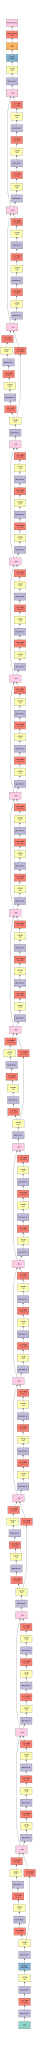

In [3]:
mx.viz.plot_network(sym)

Both argument parameters and auxiliary parameters (e.g mean/std in batch normalization layer) are stored as a dictionary of string name and ndarray value (see [ndarray.ipynb](../basic/ndarray.ipynb)). The arguments contain 
consist of weight and bias. 

In [4]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
arg_params

{'bn0_beta': <mxnet.ndarray.NDArray at 0x7f4a0d631250>,
 'bn0_gamma': <mxnet.ndarray.NDArray at 0x7f4a0d617d90>,
 'bn1_beta': <mxnet.ndarray.NDArray at 0x7f4a0d624d90>,
 'bn1_gamma': <mxnet.ndarray.NDArray at 0x7f4a0d62b7d0>,
 'bn_data_beta': <mxnet.ndarray.NDArray at 0x7f4a0d611250>,
 'bn_data_gamma': <mxnet.ndarray.NDArray at 0x7f4a0d624490>,
 'conv0_weight': <mxnet.ndarray.NDArray at 0x7f4a0d61e050>,
 'fc1_bias': <mxnet.ndarray.NDArray at 0x7f4a0d6245d0>,
 'fc1_weight': <mxnet.ndarray.NDArray at 0x7f4a0d6310d0>,
 'stage1_unit1_bn1_beta': <mxnet.ndarray.NDArray at 0x7f4a0d624a10>,
 'stage1_unit1_bn1_gamma': <mxnet.ndarray.NDArray at 0x7f4a0d61ec50>,
 'stage1_unit1_bn2_beta': <mxnet.ndarray.NDArray at 0x7f4a0d624890>,
 'stage1_unit1_bn2_gamma': <mxnet.ndarray.NDArray at 0x7f4a0d617890>,
 'stage1_unit1_bn3_beta': <mxnet.ndarray.NDArray at 0x7f4a0d6241d0>,
 'stage1_unit1_bn3_gamma': <mxnet.ndarray.NDArray at 0x7f4a0d624910>,
 'stage1_unit1_conv1_weight': <mxnet.ndarray.NDArray at 0x7f4a

while auxiliaries contains the the mean and std for the batch normalization layers.   

In [5]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
aux_params

{'bn0_moving_mean': <mxnet.ndarray.NDArray at 0x7f4a0d611150>,
 'bn0_moving_var': <mxnet.ndarray.NDArray at 0x7f4a0d624610>,
 'bn1_moving_mean': <mxnet.ndarray.NDArray at 0x7f4a0d617110>,
 'bn1_moving_var': <mxnet.ndarray.NDArray at 0x7f4a0d617990>,
 'bn_data_moving_mean': <mxnet.ndarray.NDArray at 0x7f4a0d617910>,
 'bn_data_moving_var': <mxnet.ndarray.NDArray at 0x7f4a0d611810>,
 'stage1_unit1_bn1_moving_mean': <mxnet.ndarray.NDArray at 0x7f4a0d617250>,
 'stage1_unit1_bn1_moving_var': <mxnet.ndarray.NDArray at 0x7f4a0d617b10>,
 'stage1_unit1_bn2_moving_mean': <mxnet.ndarray.NDArray at 0x7f4a0d62bf10>,
 'stage1_unit1_bn2_moving_var': <mxnet.ndarray.NDArray at 0x7f4a0d61ed50>,
 'stage1_unit1_bn3_moving_mean': <mxnet.ndarray.NDArray at 0x7f4a0d62b410>,
 'stage1_unit1_bn3_moving_var': <mxnet.ndarray.NDArray at 0x7f4a0d61e690>,
 'stage1_unit2_bn1_moving_mean': <mxnet.ndarray.NDArray at 0x7f4a0d61e6d0>,
 'stage1_unit2_bn1_moving_var': <mxnet.ndarray.NDArray at 0x7f4a0d624dd0>,
 'stage1_unit

Next we create an executable `module` (see [module.ipynb](../basic/module.ipynb)) on GPU 0. To use a difference device, we just need to charge the context, e.g. `mx.cpu()` for CPU and `mx.gpu(2)` for the 3rd GPU. 

In [6]:
mod = mx.mod.Module(symbol=sym, context=mx.gpu())

The ResNet is trained with RGB images of size 224 x 224. The training data is feed by the variable `data`. We bind the module with the input shape and specify that it is only for predicting. The number 1 added before the image shape (3x224x224) means that we will only predict one image each time. Next we set the loaded parameters. Now the module is ready to run. 

In [7]:
mod.bind(for_training = False,
         data_shapes=[('data', (1,3,224,224))])
mod.set_params(arg_params, aux_params)

## Prepare data

We first obtain the synset file, in which the i-th line contains the label for the i-th class.

In [8]:
download('http://data.mxnet.io/models/imagenet/resnet/synset.txt')
with open('synset.txt') as f:
    synsets = [l.rstrip() for l in f]

We next download 1000 images for testing, which were not used for the training. 

In [9]:
import tarfile
download('http://data.mxnet.io/data/val_1000.tar')
tfile = tarfile.open('val_1000.tar')
tfile.extractall()
with open('val_1000/label') as f:
    val_label = [int(l.split('\t')[0]) for l in f]

Visualize the first 8 images.

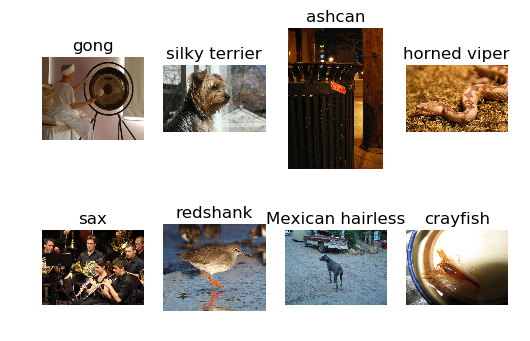

In [10]:
%matplotlib inline
import matplotlib
matplotlib.rc("savefig", dpi=100)
import matplotlib.pyplot as plt
import cv2
for i in range(0,8):
    img = cv2.cvtColor(cv2.imread('val_1000/%d.jpg' % (i,)), cv2.COLOR_BGR2RGB)
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.axis('off')
    label = synsets[val_label[i]]
    label = ' '.join(label.split(',')[0].split(' ')[1:])
    plt.title(label)

Next we define a function that reads one image each time and convert to a format can be used by the model. Here we use a naive way that resizes the original image into the desired shape, and change the data layout. 

In [11]:
import numpy as np
import cv2
def get_image(filename):
    img = cv2.imread(filename)  # read image in b,g,r order
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # change to r,g,b order
    img = cv2.resize(img, (224, 224))  # resize to 224*224 to fit model
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)  # change to (channel, height, width)
    img = img[np.newaxis, :]  # extend to (example, channel, heigth, width)
    return img

Finally we define a input data structure which is acceptable by mxnet. The field `data` is used for the input data, which is a list of NDArrays. 

In [12]:
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

## Predict

Now we are ready to run the prediction by `forward`. Then we can get the output using `get_outputs`, in which the i-th element is the predicted probability that the image contains the i-th class. 

In [13]:
img = get_image('val_1000/0.jpg')
mod.forward(Batch([mx.nd.array(img)]))
prob = mod.get_outputs()[0].asnumpy()
y = np.argsort(np.squeeze(prob))[::-1]
print('truth label %d; top-1 predict label %d' % (val_label[0], y[0]))


truth label 577; top-1 predict label 577


When predicting more than one images, we can batch several images together which potentially improves the performance. 

In [14]:
batch_size = 32
mod2 = mx.mod.Module(symbol=sym, context=mx.gpu())
mod2.bind(for_training=False, data_shapes=[('data', (batch_size,3,224,224))])
mod2.set_params(arg_params, aux_params)

Now we iterative multiple images to calculate the accuracy

In [15]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
import time
acc = 0.0
total = 0.0
for i in range(0, 200/batch_size):
    tic = time.time()
    idx = range(i*batch_size, (i+1)*batch_size)
    img = np.concatenate([get_image('val_1000/%d.jpg'%(j)) for j in idx])
    mod2.forward(Batch([mx.nd.array(img)]))
    prob = mod2.get_outputs()[0].asnumpy()
    pred = np.argsort(prob, axis=1)
    top1 = pred[:,-1]
    acc += sum(top1 == np.array([val_label[j] for j in idx]))
    total += len(idx)
    print('batch %d, time %f sec'%(i, time.time()-tic))
assert acc/total > 0.66, "Low top-1 accuracy."
print('top-1 accuracy %f'%(acc/total))

batch 0, time 0.516563 sec
batch 1, time 0.381650 sec
batch 2, time 0.372722 sec
batch 3, time 0.359430 sec
batch 4, time 0.554454 sec
batch 5, time 0.360389 sec
top-1 accuracy 0.677083


## Extract Features

Sometime we want the internal outputs from a neural network rather than then final predicted probabilities. In this way, the neural network works as a feature extraction module to other applications. 

A loaded symbol in default only returns the last layer as output. But we can get all internal layers by `get_internals`, which returns a new symbol outputting all internal layers. The following codes print the last 10 layer names. 

We can also use `mx.viz.plot_network(sym)` to visually find the name of the layer we want to use. The name conventions of the output is the layer name with `_output` as the postfix.

In [16]:
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:-1]

['bn1_beta',
 'bn1_output',
 'relu1_output',
 'pool1_output',
 'flatten0_output',
 'fc1_weight',
 'fc1_bias',
 'fc1_output',
 'softmax_label']

Often we want to use the output before the last fully connected layers, which may return semantic features of the raw images but not too fitting to the label yet. In the ResNet case, it is the flatten layer with name `flatten0` before the last fullc layer. The following codes get the new symbol `sym3` which use the flatten layer as the last output layer, and initialize a new module.

In [17]:
all_layers = sym.get_internals()
sym3 = all_layers['flatten0_output']
mod3 = mx.mod.Module(symbol=sym3, context=mx.gpu())
mod3.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
mod3.set_params(arg_params, aux_params)


Now we can do feature extraction using `forward1` as before. Notice that the last convolution layer uses 2048 channels, and we then perform an average pooling, so the output size of the flatten layer is 2048.

In [18]:
img = get_image('val_1000/0.jpg')
mod3.forward(Batch([mx.nd.array(img)]))
out = mod3.get_outputs()[0].asnumpy()
print(out.shape)

(1, 2048)


## Further Readings
